In [1]:
# library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from slice_ojh import split_stock, split_mm
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
x = np.load('x_data.npy', allow_pickle = 'True')

In [3]:
# data preprocess
def prepro(data, method):
    if method == 'minmax':
        scaler = MinMaxScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'stand':
        scaler = StandardScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'robust':
        scaler = RobustScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)

### Xgboost

(555, 25) (555, 1)
(499, 25) (499, 1)
(56, 25) (56, 1)


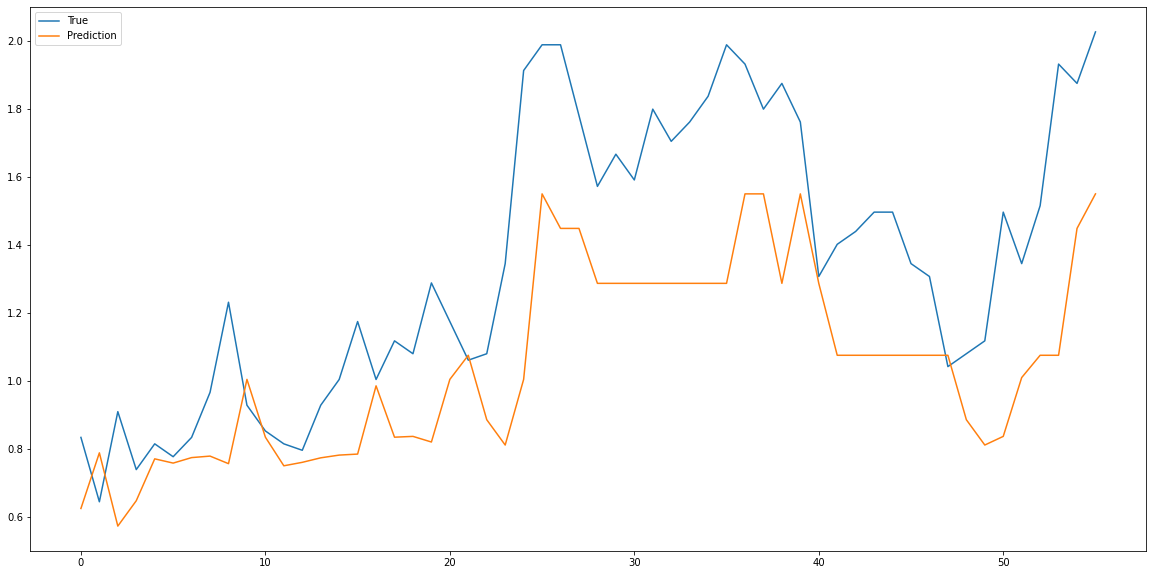

In [4]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

# close data
features, labels = split_mm(x_stand, 25, 1)
print(features.shape, labels.shape)

# split data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# training Xgboost
xgb = XGBRegressor(learning_rate=0.01, n_estimators=100, max_depth=5, random_state=3)
xgb_fit = xgb.fit(x_train, y_train)

# predict
xgb_pred = xgb.predict(x_test)

# plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(xgb_pred, label='Prediction')
ax.legend()
plt.show()

[09:14:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsmaple_bylevel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:14:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsmaple_bylevel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:14:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsmaple_bylevel } might not be used.

  This may not be accurate due to some parameters are 


[09:14:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsmaple_bylevel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:14:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsmaple_bylevel } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:14:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsmaple_bylevel } might not be used.

  This may not be accurate due to some parameters are


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000265CF8AECC8>,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=5, min_child_weight=1,
                                          missing=nan,
                                          monotone_...
                                          verbosity=None),
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                      

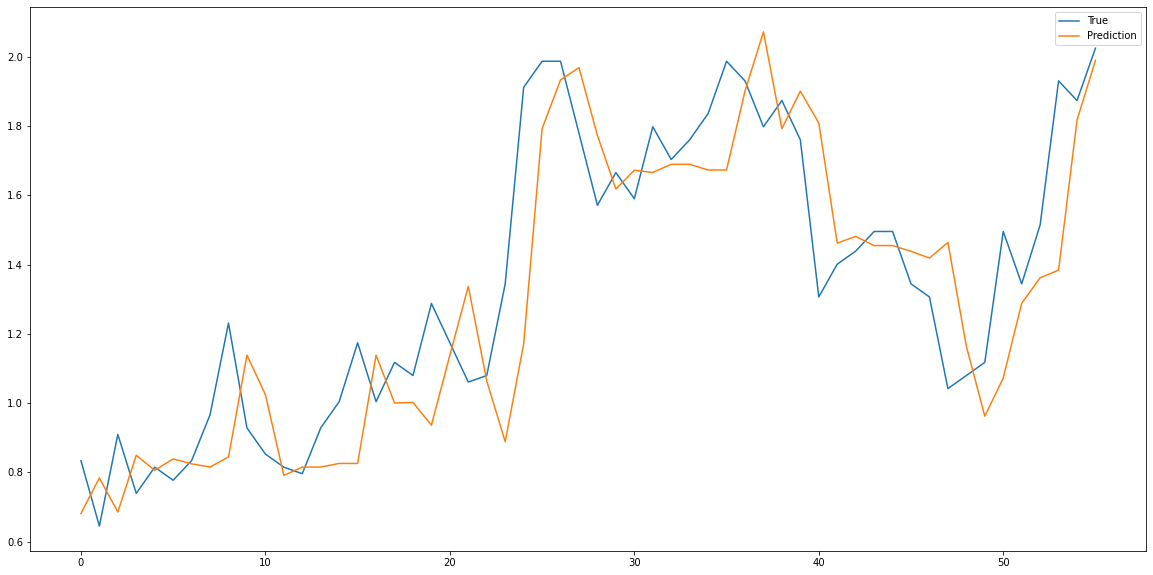

In [11]:
# Xgboost hyperparameter
params = {
    'learning_rate':[0.01,0.05,0.1,0.15,0.2],
    'n_estimators':[50,100,150,200],
    'max_depth':[3,5,7,9],
    'subsample':[0.6,0.8,1.0],
    'min_child_weight':[1,5,10],
    'gamma':[0.5,1,1.5,2],
    'max_delta_step':[1,3,5,7,9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'colsmaple_bylevel':[0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree':[0.6,0.7,0.8,0.9,1.0]}
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(xgb, params, cv=time_cv)
best_xgb = search.fit(x_train, y_train, verbose=2)
best_param = search.best_params_
print(best_xgb)
print(best_param)

best_pred = best_xgb.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

In [36]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

In [47]:
# today close
x_today = x_stand[-25:]
x_today = x_today[np.newaxis,:]
tmp = best_xgb.predict(x_today)
print(tmp)
pred_today = scaler.inverse_transform(tmp)
print(pred_today)

[2.004816]
[59089.45]


In [48]:
# atfer 2day
x_today2 = x_stand[-24:]
x_today2 = np.append(x_today2, tmp)
x_today2 = x_today2[np.newaxis,:]
tmp2= best_xgb.predict(x_today2)
print(tmp2)
pred_today2 = scaler.inverse_transform(tmp2)
print(pred_today2)

[2.0260305]
[59201.574]


In [49]:
# atfer 3day
x_today3 = x_stand[-23:]
x_today3 = np.append(x_today3, tmp)
x_today3 = np.append(x_today3, tmp2)
x_today3 = x_today3[np.newaxis,:]
tmp3 = best_xgb.predict(x_today3)
print(tmp3)
pred_today = scaler.inverse_transform(tmp3)
print(pred_today)

[2.0400646]
[59275.75]


In [50]:
# atfer 4day
x_today4 = x_stand[-22:]
x_today4 = np.append(x_today4, tmp)
x_today4 = np.append(x_today4, tmp2)
x_today4 = np.append(x_today4, tmp3)
x_today4 = x_today4[np.newaxis,:]
tmp3 = best_xgb.predict(x_today4)
print(tmp3)
pred_today = scaler.inverse_transform(tmp3)
print(pred_today)

[2.0642767]
[59403.723]


In [46]:
print(x_today.shape)
print(x_today)
print(x_today4)
print(x_today4.shape)

(1, 25)
[[1.79869198 1.7040918  1.76085191 1.83653205 1.98789235 1.93113224
  1.79869198 1.87437213 1.76085191 1.30677103 1.40137122 1.43921129
  1.4959714  1.4959714  1.34461111 1.30677103 1.04189052 1.0797306
  1.11757067 1.4959714  1.34461111 1.51489143 1.93113224 1.87437213
  2.02573242]]
[[[1.79869198 1.7040918  1.76085191 1.83653205 1.98789235 1.93113224
   1.79869198 1.87437213 1.76085191 1.30677103 1.40137122 1.43921129
   1.4959714  1.4959714  1.34461111 1.30677103 1.04189052 1.0797306
   1.11757067 1.4959714  1.34461111 1.51489143 1.93113224 1.87437213
   2.02573242]]]
(1, 1, 25)


### LSTM

In [55]:
# data preprocess
x_stand = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_stand[:,i] = prepro(x[:,i], 'stand')

# data slice
features, labels = split_stock(x_stand, 25, 4, 3)
print(features.shape, labels.shape)

(552, 25, 5) (552, 4)


In [56]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(496, 25, 5) (496, 4)
(56, 25, 5) (56, 4)


In [59]:
# LSTM model
def LSTM_model(drop=0.5, optimizer = 'adam'):
    inputs = Input(shape= (25,5), name = 'input')
    x = LSTM(512, activation = 'relu', name = 'hidden1', return_sequences=True)(inputs)
    x = Dropout(drop)(x)
    x = LSTM(256, activation = 'relu', name = 'hidden1')(inputs)
    x = Dropout(drop)(x)
    x = Dense(100, activation = 'relu', name = 'hidden2')(x)
    x = Dropout(drop)(x)
    x = Dense(50, activation = 'relu', name = 'hidden3')(x)
    x = Dropout(drop)(x)
    #x = Dense(20, activation = 'relu', name = 'hidden4')(x)
    outputs = Dense(4, name = 'output')(x)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
    return model

# parameter
def create_hyperparameters(): # epochs, node, acivation 추가 가능
    batches = [16, 32, 64]
    optimizers = ['rmsprop', 'adam', 'adadelta']
    dropout = [0.1, 0.2, 0.3, 0.4, 0.5]                           
    return {'batch_size' : batches, 'optimizer': optimizers, 
           'drop': dropout}

# wrapper
model = KerasRegressor(build_fn = LSTM_model, verbose = 2)

Train on 86 samples
Epoch 1/30
86/86 - 2s - loss: 0.3272 - mse: 0.3272
Epoch 2/30
86/86 - 0s - loss: 0.3251 - mse: 0.3251
Epoch 3/30
86/86 - 0s - loss: 0.3273 - mse: 0.3273
Epoch 4/30
86/86 - 0s - loss: 0.3268 - mse: 0.3268
Epoch 5/30
86/86 - 0s - loss: 0.3204 - mse: 0.3204
Epoch 6/30
86/86 - 0s - loss: 0.3237 - mse: 0.3237
Epoch 7/30
86/86 - 0s - loss: 0.3244 - mse: 0.3244
Epoch 8/30
86/86 - 0s - loss: 0.3242 - mse: 0.3242
Epoch 9/30
86/86 - 0s - loss: 0.3252 - mse: 0.3252
Epoch 10/30
86/86 - 0s - loss: 0.3271 - mse: 0.3271
Epoch 11/30
86/86 - 0s - loss: 0.3205 - mse: 0.3205
Epoch 12/30
86/86 - 0s - loss: 0.3219 - mse: 0.3219
Epoch 13/30
86/86 - 0s - loss: 0.3223 - mse: 0.3223
Epoch 14/30
86/86 - 0s - loss: 0.3219 - mse: 0.3219
Epoch 15/30
86/86 - 0s - loss: 0.3204 - mse: 0.3204
Epoch 16/30
86/86 - 0s - loss: 0.3174 - mse: 0.3174
Epoch 17/30
86/86 - 0s - loss: 0.3203 - mse: 0.3203
Epoch 18/30
86/86 - 0s - loss: 0.3220 - mse: 0.3220
Epoch 19/30
86/86 - 0s - loss: 0.3196 - mse: 0.3196
E

Epoch 30/30
414/414 - 1s - loss: 0.9346 - mse: 0.9346
82/1 - 0s - loss: 0.5318 - mse: 0.5653
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.2836 - mse: 0.2836
Epoch 2/30
86/86 - 0s - loss: 0.2854 - mse: 0.2854
Epoch 3/30
86/86 - 0s - loss: 0.2840 - mse: 0.2840
Epoch 4/30
86/86 - 0s - loss: 0.2837 - mse: 0.2837
Epoch 5/30
86/86 - 0s - loss: 0.2816 - mse: 0.2816
Epoch 6/30
86/86 - 0s - loss: 0.2829 - mse: 0.2829
Epoch 7/30
86/86 - 0s - loss: 0.2809 - mse: 0.2809
Epoch 8/30
86/86 - 0s - loss: 0.2849 - mse: 0.2849
Epoch 9/30
86/86 - 0s - loss: 0.2851 - mse: 0.2851
Epoch 10/30
86/86 - 0s - loss: 0.2817 - mse: 0.2817
Epoch 11/30
86/86 - 0s - loss: 0.2809 - mse: 0.2809
Epoch 12/30
86/86 - 0s - loss: 0.2831 - mse: 0.2831
Epoch 13/30
86/86 - 0s - loss: 0.2800 - mse: 0.2800
Epoch 14/30
86/86 - 0s - loss: 0.2813 - mse: 0.2813
Epoch 15/30
86/86 - 0s - loss: 0.2831 - mse: 0.2831
Epoch 16/30
86/86 - 0s - loss: 0.2825 - mse: 0.2825
Epoch 17/30
86/86 - 0s - loss: 0.2817 - mse: 0.2817
Epoch 18/30


414/414 - 1s - loss: 0.9799 - mse: 0.9799
Epoch 29/30
414/414 - 1s - loss: 0.9793 - mse: 0.9793
Epoch 30/30
414/414 - 1s - loss: 0.9774 - mse: 0.9774
82/1 - 0s - loss: 0.7016 - mse: 0.5872
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.1945 - mse: 0.1945
Epoch 2/30
86/86 - 0s - loss: 0.0614 - mse: 0.0614
Epoch 3/30
86/86 - 0s - loss: 0.0652 - mse: 0.0652
Epoch 4/30
86/86 - 0s - loss: 0.0585 - mse: 0.0585
Epoch 5/30
86/86 - 0s - loss: 0.0553 - mse: 0.0553
Epoch 6/30
86/86 - 0s - loss: 0.0530 - mse: 0.0530
Epoch 7/30
86/86 - 0s - loss: 0.0525 - mse: 0.0525
Epoch 8/30
86/86 - 0s - loss: 0.0493 - mse: 0.0493
Epoch 9/30
86/86 - 0s - loss: 0.0488 - mse: 0.0488
Epoch 10/30
86/86 - 0s - loss: 0.0425 - mse: 0.0425
Epoch 11/30
86/86 - 0s - loss: 0.0482 - mse: 0.0482
Epoch 12/30
86/86 - 0s - loss: 0.0425 - mse: 0.0425
Epoch 13/30
86/86 - 0s - loss: 0.0496 - mse: 0.0496
Epoch 14/30
86/86 - 0s - loss: 0.0407 - mse: 0.0407
Epoch 15/30
86/86 - 0s - loss: 0.0433 - mse: 0.0433
Epoch 16/30
86/86 - 

Epoch 27/30
414/414 - 1s - loss: 0.0771 - mse: 0.0771
Epoch 28/30
414/414 - 1s - loss: 0.0715 - mse: 0.0715
Epoch 29/30
414/414 - 1s - loss: 0.0710 - mse: 0.0710
Epoch 30/30
414/414 - 1s - loss: 0.0660 - mse: 0.0660
82/1 - 0s - loss: 1.6013 - mse: 2.4836
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.3171 - mse: 0.3171
Epoch 2/30
86/86 - 0s - loss: 0.3193 - mse: 0.3193
Epoch 3/30
86/86 - 0s - loss: 0.3219 - mse: 0.3219
Epoch 4/30
86/86 - 0s - loss: 0.3224 - mse: 0.3224
Epoch 5/30
86/86 - 0s - loss: 0.3190 - mse: 0.3190
Epoch 6/30
86/86 - 0s - loss: 0.3203 - mse: 0.3203
Epoch 7/30
86/86 - 0s - loss: 0.3220 - mse: 0.3220
Epoch 8/30
86/86 - 0s - loss: 0.3231 - mse: 0.3231
Epoch 9/30
86/86 - 0s - loss: 0.3142 - mse: 0.3142
Epoch 10/30
86/86 - 0s - loss: 0.3162 - mse: 0.3162
Epoch 11/30
86/86 - 0s - loss: 0.3208 - mse: 0.3208
Epoch 12/30
86/86 - 0s - loss: 0.3228 - mse: 0.3228
Epoch 13/30
86/86 - 0s - loss: 0.3203 - mse: 0.3203
Epoch 14/30
86/86 - 0s - loss: 0.3201 - mse: 0.3201
Epoch 

414/414 - 1s - loss: 0.9854 - mse: 0.9854
Epoch 26/30
414/414 - 1s - loss: 0.9745 - mse: 0.9745
Epoch 27/30
414/414 - 1s - loss: 0.9693 - mse: 0.9693
Epoch 28/30
414/414 - 1s - loss: 0.9740 - mse: 0.9740
Epoch 29/30
414/414 - 1s - loss: 0.9770 - mse: 0.9770
Epoch 30/30
414/414 - 1s - loss: 0.9880 - mse: 0.9880
82/1 - 0s - loss: 0.5632 - mse: 0.5918
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.2864 - mse: 0.2864
Epoch 2/30
86/86 - 0s - loss: 0.2432 - mse: 0.2432
Epoch 3/30
86/86 - 0s - loss: 0.2123 - mse: 0.2123
Epoch 4/30
86/86 - 0s - loss: 0.1511 - mse: 0.1511
Epoch 5/30
86/86 - 0s - loss: 0.1484 - mse: 0.1484
Epoch 6/30
86/86 - 0s - loss: 0.1272 - mse: 0.1272
Epoch 7/30
86/86 - 0s - loss: 0.1257 - mse: 0.1257
Epoch 8/30
86/86 - 0s - loss: 0.1299 - mse: 0.1299
Epoch 9/30
86/86 - 0s - loss: 0.1039 - mse: 0.1039
Epoch 10/30
86/86 - 0s - loss: 0.1017 - mse: 0.1017
Epoch 11/30
86/86 - 0s - loss: 0.1100 - mse: 0.1100
Epoch 12/30
86/86 - 0s - loss: 0.0893 - mse: 0.0893
Epoch 13/30
86

Epoch 24/30
414/414 - 1s - loss: 0.1859 - mse: 0.1859
Epoch 25/30
414/414 - 1s - loss: 0.1753 - mse: 0.1753
Epoch 26/30
414/414 - 1s - loss: 0.1879 - mse: 0.1879
Epoch 27/30
414/414 - 1s - loss: 0.1759 - mse: 0.1759
Epoch 28/30
414/414 - 1s - loss: 0.2034 - mse: 0.2034
Epoch 29/30
414/414 - 1s - loss: 0.2108 - mse: 0.2108
Epoch 30/30
414/414 - 1s - loss: 0.1949 - mse: 0.1949
82/1 - 0s - loss: 0.9402 - mse: 1.4788
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.2628 - mse: 0.2628
Epoch 2/30
86/86 - 0s - loss: 0.1324 - mse: 0.1324
Epoch 3/30
86/86 - 0s - loss: 0.1136 - mse: 0.1136
Epoch 4/30
86/86 - 0s - loss: 0.1314 - mse: 0.1314
Epoch 5/30
86/86 - 0s - loss: 0.1068 - mse: 0.1068
Epoch 6/30
86/86 - 0s - loss: 0.0747 - mse: 0.0747
Epoch 7/30
86/86 - 0s - loss: 0.0649 - mse: 0.0649
Epoch 8/30
86/86 - 0s - loss: 0.0695 - mse: 0.0695
Epoch 9/30
86/86 - 0s - loss: 0.0768 - mse: 0.0768
Epoch 10/30
86/86 - 0s - loss: 0.0728 - mse: 0.0728
Epoch 11/30
86/86 - 0s - loss: 0.0631 - mse: 0.0631


Epoch 22/30
414/414 - 0s - loss: 0.1330 - mse: 0.1330
Epoch 23/30
414/414 - 0s - loss: 0.1313 - mse: 0.1313
Epoch 24/30
414/414 - 0s - loss: 0.1374 - mse: 0.1374
Epoch 25/30
414/414 - 0s - loss: 0.1346 - mse: 0.1346
Epoch 26/30
414/414 - 0s - loss: 0.1433 - mse: 0.1433
Epoch 27/30
414/414 - 0s - loss: 0.1093 - mse: 0.1093
Epoch 28/30
414/414 - 0s - loss: 0.1378 - mse: 0.1378
Epoch 29/30
414/414 - 0s - loss: 0.1137 - mse: 0.1137
Epoch 30/30
414/414 - 0s - loss: 0.1386 - mse: 0.1386
82/1 - 0s - loss: 0.6656 - mse: 1.0832
Train on 86 samples
Epoch 1/30
86/86 - 2s - loss: 0.1379 - mse: 0.1379
Epoch 2/30
86/86 - 0s - loss: 0.0726 - mse: 0.0726
Epoch 3/30
86/86 - 0s - loss: 0.0590 - mse: 0.0590
Epoch 4/30
86/86 - 0s - loss: 0.0592 - mse: 0.0592
Epoch 5/30
86/86 - 0s - loss: 0.0620 - mse: 0.0620
Epoch 6/30
86/86 - 0s - loss: 0.0575 - mse: 0.0575
Epoch 7/30
86/86 - 0s - loss: 0.0521 - mse: 0.0521
Epoch 8/30
86/86 - 0s - loss: 0.0504 - mse: 0.0504
Epoch 9/30
86/86 - 0s - loss: 0.0437 - mse: 0.0

Epoch 20/30
414/414 - 1s - loss: 0.1049 - mse: 0.1049
Epoch 21/30
414/414 - 1s - loss: 0.0858 - mse: 0.0858
Epoch 22/30
414/414 - 1s - loss: 0.0888 - mse: 0.0888
Epoch 23/30
414/414 - 1s - loss: 0.0938 - mse: 0.0938
Epoch 24/30
414/414 - 1s - loss: 0.0968 - mse: 0.0968
Epoch 25/30
414/414 - 1s - loss: 0.0913 - mse: 0.0913
Epoch 26/30
414/414 - 1s - loss: 0.0977 - mse: 0.0977
Epoch 27/30
414/414 - 1s - loss: 0.0995 - mse: 0.0995
Epoch 28/30
414/414 - 1s - loss: 0.0898 - mse: 0.0898
Epoch 29/30
414/414 - 1s - loss: 0.0821 - mse: 0.0821
Epoch 30/30
414/414 - 1s - loss: 0.0785 - mse: 0.0785
82/1 - 0s - loss: 0.9400 - mse: 1.1120
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.1804 - mse: 0.1804
Epoch 2/30
86/86 - 0s - loss: 0.0863 - mse: 0.0863
Epoch 3/30
86/86 - 0s - loss: 0.0854 - mse: 0.0854
Epoch 4/30
86/86 - 0s - loss: 0.0625 - mse: 0.0625
Epoch 5/30
86/86 - 0s - loss: 0.0830 - mse: 0.0830
Epoch 6/30
86/86 - 0s - loss: 0.0715 - mse: 0.0715
Epoch 7/30
86/86 - 0s - loss: 0.0525 - ms

414/414 - 1s - loss: 0.1139 - mse: 0.1139
Epoch 19/30
414/414 - 1s - loss: 0.1152 - mse: 0.1152
Epoch 20/30
414/414 - 1s - loss: 0.1083 - mse: 0.1083
Epoch 21/30
414/414 - 1s - loss: 0.1043 - mse: 0.1043
Epoch 22/30
414/414 - 1s - loss: 0.1064 - mse: 0.1064
Epoch 23/30
414/414 - 1s - loss: 0.0964 - mse: 0.0964
Epoch 24/30
414/414 - 1s - loss: 0.1192 - mse: 0.1192
Epoch 25/30
414/414 - 1s - loss: 0.0999 - mse: 0.0999
Epoch 26/30
414/414 - 1s - loss: 0.1066 - mse: 0.1066
Epoch 27/30
414/414 - 1s - loss: 0.1055 - mse: 0.1055
Epoch 28/30
414/414 - 1s - loss: 0.0992 - mse: 0.0992
Epoch 29/30
414/414 - 1s - loss: 0.1088 - mse: 0.1088
Epoch 30/30
414/414 - 1s - loss: 0.1237 - mse: 0.1237
82/1 - 0s - loss: 0.4428 - mse: 0.5963
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.2703 - mse: 0.2703
Epoch 2/30
86/86 - 0s - loss: 0.1723 - mse: 0.1723
Epoch 3/30
86/86 - 0s - loss: 0.0950 - mse: 0.0950
Epoch 4/30
86/86 - 0s - loss: 0.0710 - mse: 0.0710
Epoch 5/30
86/86 - 0s - loss: 0.0652 - mse: 0.0

414/414 - 1s - loss: 0.0954 - mse: 0.0954
Epoch 17/30
414/414 - 1s - loss: 0.0897 - mse: 0.0897
Epoch 18/30
414/414 - 1s - loss: 0.0844 - mse: 0.0844
Epoch 19/30
414/414 - 1s - loss: 0.0895 - mse: 0.0895
Epoch 20/30
414/414 - 1s - loss: 0.0861 - mse: 0.0861
Epoch 21/30
414/414 - 1s - loss: 0.0774 - mse: 0.0774
Epoch 22/30
414/414 - 1s - loss: 0.0759 - mse: 0.0759
Epoch 23/30
414/414 - 1s - loss: 0.0893 - mse: 0.0893
Epoch 24/30
414/414 - 1s - loss: 0.0738 - mse: 0.0738
Epoch 25/30
414/414 - 1s - loss: 0.0759 - mse: 0.0759
Epoch 26/30
414/414 - 1s - loss: 0.0731 - mse: 0.0731
Epoch 27/30
414/414 - 1s - loss: 0.0755 - mse: 0.0755
Epoch 28/30
414/414 - 1s - loss: 0.0760 - mse: 0.0760
Epoch 29/30
414/414 - 1s - loss: 0.0706 - mse: 0.0706
Epoch 30/30
414/414 - 1s - loss: 0.0686 - mse: 0.0686
82/1 - 0s - loss: 1.2720 - mse: 2.1577
Train on 86 samples
Epoch 1/30
86/86 - 1s - loss: 0.2868 - mse: 0.2868
Epoch 2/30
86/86 - 0s - loss: 0.2872 - mse: 0.2872
Epoch 3/30
86/86 - 0s - loss: 0.2865 - ms

Epoch 15/30
414/414 - 1s - loss: 0.9807 - mse: 0.9807
Epoch 16/30
414/414 - 1s - loss: 0.9801 - mse: 0.9801
Epoch 17/30
414/414 - 1s - loss: 0.9769 - mse: 0.9769
Epoch 18/30
414/414 - 1s - loss: 0.9724 - mse: 0.9724
Epoch 19/30
414/414 - 1s - loss: 0.9737 - mse: 0.9737
Epoch 20/30
414/414 - 1s - loss: 0.9712 - mse: 0.9712
Epoch 21/30
414/414 - 1s - loss: 0.9682 - mse: 0.9682
Epoch 22/30
414/414 - 1s - loss: 0.9672 - mse: 0.9672
Epoch 23/30
414/414 - 1s - loss: 0.9635 - mse: 0.9635
Epoch 24/30
414/414 - 1s - loss: 0.9655 - mse: 0.9655
Epoch 25/30
414/414 - 1s - loss: 0.9589 - mse: 0.9589
Epoch 26/30
414/414 - 1s - loss: 0.9566 - mse: 0.9566
Epoch 27/30
414/414 - 1s - loss: 0.9518 - mse: 0.9518
Epoch 28/30
414/414 - 1s - loss: 0.9553 - mse: 0.9553
Epoch 29/30
414/414 - 1s - loss: 0.9507 - mse: 0.9507
Epoch 30/30
414/414 - 1s - loss: 0.9487 - mse: 0.9487
82/1 - 0s - loss: 0.5316 - mse: 0.5696
Train on 496 samples
Epoch 1/30
496/496 - 2s - loss: 0.7760 - mse: 0.7760
Epoch 2/30
496/496 - 1s

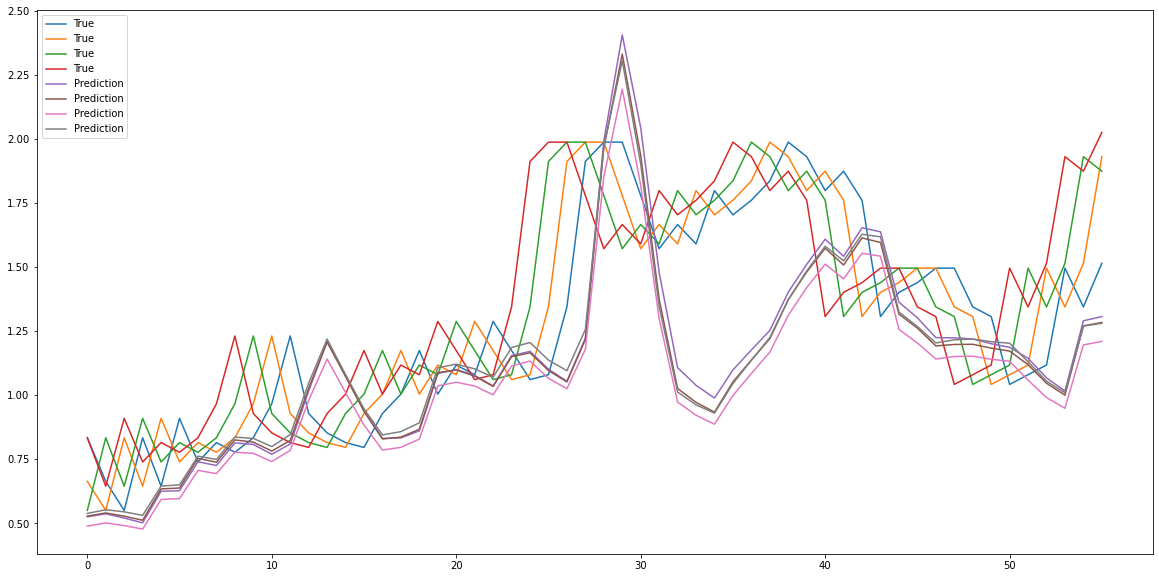

In [60]:
hyperparameters = create_hyperparameters()
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(model, hyperparameters, cv = time_cv)

best_LSTM = search.fit(x_train, y_train, epochs=30, verbose=2)
best_param = search.best_params_
print(best_LSTM)
print(best_param)

best_pred = best_LSTM.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

In [61]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)

# today close
x_today = x_stand[-25:,:]
x_today = x_today[np.newaxis,:]
pred_today = best_LSTM.predict(x_today)
print(pred_today)
pred_today = pred_today[np.newaxis]
pred_today = scaler.inverse_transform(pred_today)
print(pred_today)

1/1 - 0s
[2.0536003 1.9741985 1.8583689 1.9452933]
[[59347.293 58927.62  58315.418 58774.848]]


### ARIMA

In [21]:
samsung = pd.read_csv('samsung0910.csv')
samsung = samsung[::-1]
samsung = samsung.drop(['시가','고가','저가','거래량','등락률'], axis=1)
samsung['종가'] = samsung['종가'].map(lambda x: int(re.sub(r',', '', x)))
samsung.reset_index(drop=True, inplace=True)
samsung.columns = ['date', 'close']

samsung['date'] = pd.to_datetime(samsung.date, format='%Y-%m-%d')
samsung = samsung.set_index('date')
print(samsung.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 580 entries, 2018-05-04 to 2020-09-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   580 non-null    int64
dtypes: int64(1)
memory usage: 9.1 KB
None


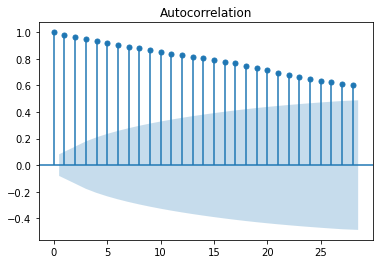

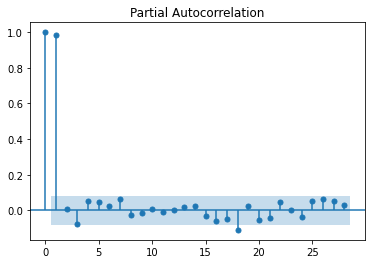

In [22]:
plot_acf(samsung) # ACF plot
plot_pacf(samsung) # PACF plot
plt.show()

In [23]:
y = samsung['close']
y_1diff = samsung.diff().dropna()['close']
result = adfuller(y)
print(f'원 데이터 ADF Statistic : {result[0] : .4f}')
print(f'원 데이터 p-value : {result[1] : .4f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic : {result[0] : .4f}')
print(f'1차 차분 p-value : {result[1] : .4f}')

원 데이터 ADF Statistic : -1.6662
원 데이터 p-value :  0.4486
1차 차분 ADF Statistic : -15.5848
1차 차분 p-value :  0.0000


In [24]:
model = ARIMA(samsung, order=(1,1,0)) # freq='D'
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  579
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4733.221
Method:                       css-mle   S.D. of innovations            859.097
Date:                Fri, 11 Sep 2020   AIC                           9472.443
Time:                        09:20:03   BIC                           9485.526
Sample:                             1   HQIC                          9477.544
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.5273     35.443      0.353      0.724     -56.940      81.994
ar.L1.D.close    -0.0073      0.042     -0.177      0.860      -0.089       0.074
                                    Root

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [25]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(4):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

predictions
#plt.plot(test.index, test['close'])
#plt.plot(test.index, predictions, color='red')
#plt.show()

[array([59206.74082756]),
 array([59219.34966592]),
 array([59231.92789804]),
 array([59244.51895831])]

In [26]:
def auto_arima(data, order, sort='AIC'):
    order_lst = []
    aic_lst = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    order_lst.append(c_order)
                    aic_lst.append(aic)
                except:
                    pass
    result_auto = pd.DataFrame(list(zip(order_lst, aic_lst)), columns=['order', 'AIC'])
    result_auto.sort_values(sort, inplace=True)
    return result_auto

result = auto_arima(samsung, [3,3,3])
result

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency infor

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency infor

,order,AIC
25,p2 d2 q1,9461.648539
7,p0 d2 q1,9462.081945
26,p2 d2 q2,9463.422320
16,p1 d2 q1,9464.044417
8,p0 d2 q2,9464.050137
17,p1 d2 q2,9464.327987
5,p0 d1 q2,9469.699158
21,p2 d1 q0,9470.013917
3,p0 d1 q0,9470.473653
14,p1 d1 q2,9471.586343


In [27]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(4):
    model = ARIMA(history, order=(0,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

predictions
#plt.plot(test.index, test['close'])
#plt.plot(test.index, predictions, color='red')
#plt.show()

[array([59284.75376033]),
 array([59370.99973795]),
 array([59457.48560903]),
 array([59544.22390353])]

In [ ]:
#samsung.index[-1] + pd.Timedelta(days=1)

In [62]:
!jupyter nbconvert --to script 0911_stock_predict.ipynb

[NbConvertApp] Converting notebook 0911_stock_predict.ipynb to script
[NbConvertApp] Writing 9611 bytes to 0911_stock_predict.py
